# Demo of a decision tree Leo transpilation - German credit dataset

## Function to download the dataset

In [29]:
import os
from zipfile import ZipFile

import requests


def download_and_extract_dataset(url, save_path, folder_path):
    """Download and extract dataset if it doesn't exist."""
    if not os.path.exists(save_path):
        print("Downloading the dataset...")
        response = requests.get(url)
        with open(save_path, "wb") as file:
            file.write(response.content)
        with ZipFile(save_path, "r") as zip_ref:
            zip_ref.extractall(folder_path)
        print(f"Dataset downloaded and extracted in {folder_path}/")
    else:
        print(f"Dataset already exists in {save_path}")

## Download the dataset

In [30]:
url = "https://archive.ics.uci.edu/static/public/144/statlog+german+credit+data.zip"
folder_name = "tmp/credit"
zip_file_name = "statlog+german+credit+data.zip"
folder_path = os.path.join(os.getcwd(), folder_name)
path_to_save = os.path.join(folder_path, zip_file_name)

os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist
download_and_extract_dataset(url, path_to_save, folder_path)

Dataset downloaded and extracted in /Users/kp/dev/python-sdk/leotranspiler/examples/decision_trees/tmp/credit/


## Load and pre-process the data

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Column definitions
columns = [
    "existing_account",
    "month_duration",
    "credit_history",
    "purpose",
    "credit_amount",
    "saving_bonds",
    "employment_status",
    "installment_rate",
    "status_sex",
    "debts_status",
    "resident_since",
    "property",
    "age",
    "installment_plans",
    "housing_status",
    "credit_number",
    "job",
    "people_liability",
    "telephone",
    "foreign",
    "result",
]

# Load data
data_filepath = os.path.join(folder_path, "german.data")
df = pd.read_csv(data_filepath, sep=" ", header=None, names=columns)

# Data pre-processing
dummy_columns = [
    "credit_history",
    "purpose",
    "status_sex",
    "debts_status",
    "property",
    "installment_plans",
    "housing_status",
    "foreign",
    "existing_account",
    "saving_bonds",
    "telephone",
    "job",
    "employment_status",
]
df_numerical = pd.get_dummies(df, columns=dummy_columns, drop_first=True)

# Splitting dataset into training and test sets
X = df_numerical.drop("result", axis=1)
y = df["result"].replace({1: 0, 2: 1})
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

## Train and evaluate the model

In [32]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

# Training the model
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

# Prediction and metrics
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"AUC score: {roc_auc_score(y_test, y_pred):.2f}")

Accuracy: 0.68
AUC score: 0.62


## Plot the decision tree

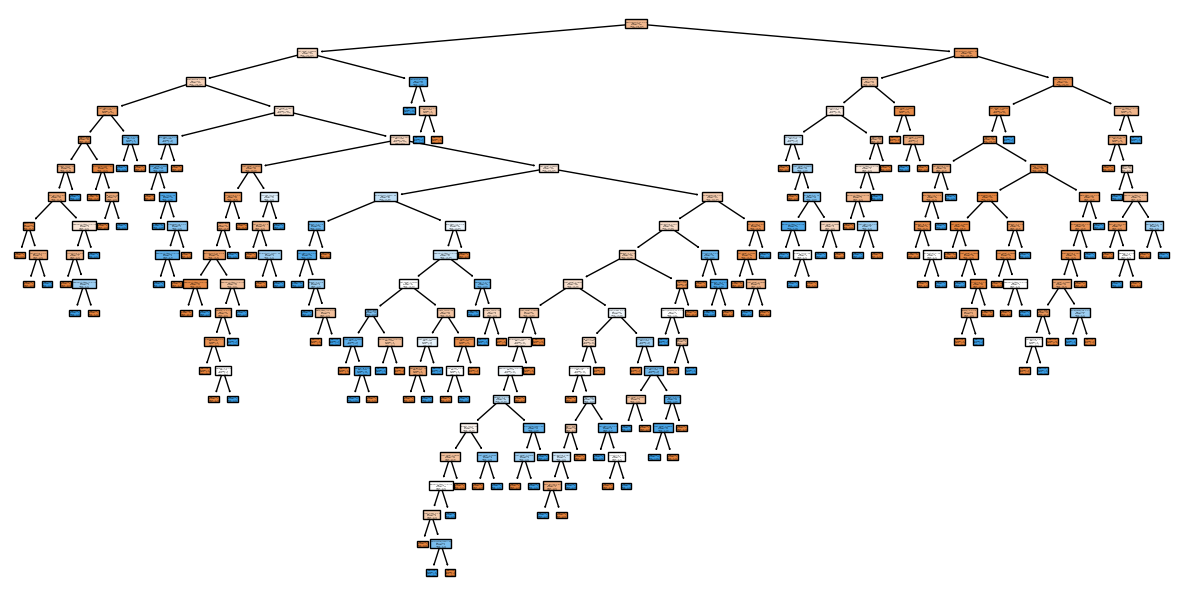

In [33]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 7.5))
plot_tree(clf, filled=True, feature_names=list(X.columns), class_names=["Good", "Bad"])
plt.show()

## Transpile the tree

In [34]:
import logging
import os

from leotranspiler import LeoTranspiler

# Set the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Transpile the deceision tree into Leo code
lt = LeoTranspiler(model=clf, validation_data=X_train)
leo_project_path = os.path.join(os.getcwd(), "tmp/credit")
leo_project_name = "tree_credit_1"
lt.to_leo(path=leo_project_path, project_name=leo_project_name)

logger.setLevel(logging.WARN)

INFO:root:Computing number ranges and fixed-point scaling factor...
INFO:root:Minimum number: -2.0, maximum number: 15945. Recommended fixed-point scaling factor: 16, required Leo type: i32
INFO:root:Transpiling model...
INFO:root:Leo program stored


## Let's take a look at the transpiled Leo code

In [35]:
# take a look at the transpiled code
leo_code_path = os.path.join(
    (os.path.join(leo_project_path, leo_project_name, "src", "main.leo"))
)
with open(leo_code_path, "r") as f:
    leo_code = f.read()
print(leo_code)

// This file was automatically generated by the LeoTranspiler.
program tree_credit_1.aleo {
    struct Struct0 {
  x0: i32,
  x1: i32,
  x2: i32
}
struct Struct1 {
  x0: i32,
  x1: i32
}
    transition main (struct0_0: Struct0, struct0_1: Struct0, struct0_2: Struct0, struct0_3: Struct0, struct0_4: Struct0, struct0_5: Struct0, struct0_6: Struct0, struct0_7: Struct0, struct0_8: Struct1, struct0_9: Struct1, struct0_10: Struct1, struct0_11: Struct1, struct0_12: Struct1, struct0_13: Struct1, struct0_14: Struct1, struct0_15: Struct1) -> (i32) {
        if struct0_11.x0 <= 8i32 {
            if struct0_0.x1 <= 173464i32 {
                if struct0_0.x0 <= 184i32 {
                    if struct0_2.x1 <= 8i32 {
                        if struct0_1.x1 <= 488i32 {
                            if struct0_8.x0 <= 8i32 {
                                if struct0_5.x2 <= 8i32 {
                                    if struct0_1.x1 <= 440i32 {
                                        return 0i32;
      

## Let's input one test data instance into the Leo and Python model and compare the predictions and labels

In [36]:
# prove and compare the Leo prediction with the Python prediction and the label
zkp = lt.execute(input_sample=X_test.iloc[0])
python_prediction = clf.predict(X_test.loc[[X_test.index[0]]])

print(f"Circuit constraints: {zkp.circuit_constraints}")
print(f"Runtime: {zkp.runtime} seconds")
print(f"Active circuit inputs: {zkp.active_input_count}")
print(f"Leo prediction in fixed-point notation: {zkp.output[0]}")
print(f"Leo prediction in decimal notation: {zkp.output_decimal[0]}")
print(f"Python prediction: {python_prediction[0]}")
print(f"Label: {y_test.iloc[0]}")
print(f"Proof: {zkp.proof}")

Circuit constraints: 6271
Runtime: 19.81935167312622 seconds
Active circuit inputs: 40
Leo prediction in fixed-point notation: 16
Leo prediction in decimal notation: 1.0
Python prediction: 1
Label: 0
Proof: proof1qqqsqqqqqqqqqqqpqqqqqqqqqqqxu6qlln5q2xkz3q2rvkva2l0hfemzqthc2caqss98q5e5ywh45uayvh5546azggqrc6nmzda66duq0e6ufhkheg5pzq4djwswxlsys3drfvx8wcwd6jgfg54sqsl4zfh03c4dqdq2sktwydpfc2dfc53cz2qkky9vfyjq0235xe377tkga9yg2ymy98na8z3hkrk9smp0md8xaj7l5lxw2du4vqalr7tgcefnqqq45vumd5sx2yssc7kp689t9vtk8cke82xkftu8xg8ztujpnawlht055ue7mcjggwmew0z6jrj8vsyp84flplxgltmlpx0ketf49yte8s5aaw3f8yrrp22t2dmk25j3lcjzsyaq4qhzqjt2p93tz4nzkargp2xc2p2w48t6frp0sgxry8ck6f7fap5c2u9kl6vzrffts0evuejcydm5aslgxtw8pgc7ewz03l9esra4zcwqfl6vkeca6z6vl3wcszh4hh33jaw28udy5snzz7aha26yp8j3vhh6azstfs82xr7s49l6lqx8rt3kupn222gpa3g9cuuwvgrnhh4ng7rhgfq5szyjxlprynte00an7vuvws0ufxe4qjqq94w4h7q8z2fu0d04de6rmqjx0ke8z9ev5rguvehgfs5tyne6h4jnfl63r9hm0qcp3k44tjse5k6mt76dzfvq8pzd0pjhmmvspndtt5eqyr35wkmx3arl5yrrqlel00yad090wrw9pek9guyh398tqdf

## Let's compare the classification accuracy for the Leo and Python model over the test data set
(this process may take a few minutes, as we iterate over the test dataset and run the leo code each time)

In [39]:
import numpy as np

# Compute the accuracy of the Leo program and the Python program on the test set
num_test_samples = len(X_test)

# let's limit the number of test stamples to make the computation faster
num_test_samples = min(num_test_samples, 50)

leo_predictions = np.zeros(num_test_samples)
for i in range(num_test_samples):
    leo_predictions[i] = lt.run(input_sample=X_test.iloc[i]).output_decimal[0]
    print("Progress: {:.2f}%".format(100 * (i + 1) / num_test_samples), end="\r")

python_predictions = clf.predict(X_test)

leo_accuracy = (
    np.sum(leo_predictions[0:num_test_samples] == y_test[0:num_test_samples])
    / num_test_samples
)
python_accuracy = (
    np.sum(python_predictions[0:num_test_samples] == y_test[0:num_test_samples])
    / num_test_samples
)

print(f"Leo accuracy: {100*leo_accuracy} %")
print(f"Python accuracy: {100*python_accuracy} %")

Leo accuracy: 57.99999999999999 %
Python accuracy: 57.99999999999999 %


## We can also set the model parameters as inputs instead of hardcoding these

In [40]:
leo_project_name = "tree_credit_2"
lt.to_leo(path=leo_project_path, project_name=leo_project_name, model_as_input=True)

## Taking a look to check ...

In [41]:
# take a look at the transpiled code
leo_code_path = os.path.join(
    (os.path.join(leo_project_path, leo_project_name, "src", "main.leo"))
)
with open(leo_code_path, "r") as f:
    leo_code = f.read()
print(leo_code)

// This file was automatically generated by the LeoTranspiler.
program tree_credit_2.aleo {
    struct Struct0 {
  x0: i32,
  x1: i32,
  x2: i32,
  x3: i32,
  x4: i32,
  x5: i32,
  x6: i32,
  x7: i32,
  x8: i32,
  x9: i32,
  x10: i32,
  x11: i32
}
struct Struct1 {
  x0: i32,
  x1: i32,
  x2: i32,
  x3: i32,
  x4: i32,
  x5: i32,
  x6: i32,
  x7: i32,
  x8: i32,
  x9: i32,
  x10: i32
}
    transition main (struct0_0: Struct0, struct0_1: Struct0, struct0_2: Struct0, struct0_3: Struct1, struct0_4: Struct1, struct0_5: Struct1, struct0_6: Struct1, struct0_7: Struct1, struct0_8: Struct1, struct0_9: Struct1, struct0_10: Struct1, struct0_11: Struct1, struct0_12: Struct1, struct0_13: Struct1, struct0_14: Struct1, struct0_15: Struct1) -> (i32) {
        if struct0_2.x6 <= struct0_3.x4 {
            if struct0_0.x1 <= struct0_3.x5 {
                if struct0_0.x0 <= struct0_3.x6 {
                    if struct0_0.x7 <= struct0_3.x7 {
                        if struct0_0.x4 <= struct0_3.x8 {
    

## Let's run the proving again
(we expect the circuit to have more inputs and slightly more constraints now, more inputs, and also the proving to run slightly longer)

In [42]:
# prove and compare the Leo prediction with the Python prediction and the label
zkp = lt.execute(input_sample=X_test.iloc[0])
python_prediction = clf.predict(X_test.loc[[X_test.index[0]]])

print(f"Circuit constraints: {zkp.circuit_constraints}")
print(f"Runtime: {zkp.runtime} seconds")
print(f"Active circuit inputs: {zkp.active_input_count}")
print(f"Leo prediction in fixed-point notation: {zkp.output[0]}")
print(f"Leo prediction in decimal notation: {zkp.output_decimal[0]}")
print(f"Python prediction: {python_prediction[0]}")
print(f"Label: {y_test.iloc[0]}")
print(f"Proof: {zkp.proof}")

Circuit constraints: 6549
Runtime: 18.909810066223145 seconds
Active circuit inputs: 179
Leo prediction in fixed-point notation: 16
Leo prediction in decimal notation: 1.0
Python prediction: 1
Label: 0
Proof: proof1qqqsqqqqqqqqqqqpqqqqqqqqqqqv3eh3j86hpt4y0efgx8xgelc9magx6zmj9s3wtvd85wwypn8pj74qvecevdnh5prn6ftr3qvpzfcqagtpeksm9aelc0hlgkzlfwh9pygam58m5d4dwrjn5jz0ju0l6nqjtuthn46h67cr9wq9kk0my3kgrsvyr8c8wnyksj0ksmzlgzxwac8aaa9rlwdtpmplv7945ywmu8gpf0nu5gtgcxmy5mvejzvv35p2qqq7lewn6xw7p60dsr8nxa56hrlk3y4eefgp323hgxzeq3788cly6c43g8wj0a49dhukg8040p4aut5pxd02hgwr96nm0x0hp5fny7wzdjazwu8vtpdl6mks2x7eafwg8vnnr09fd24tyrxcwe6pl80dzqccr25y5xnkchl743fqtw4eyly57wh6vj320r4q6atsnfadaw0j69dy3xutfurjw42wa34u8qzldvfyqyye7mgqqx2uysw4x6nv6ljpjqzdx88gy5tptepxy0wpendrk94rhglg6lhahzpvjdhwwctd7dt9yqphqah2se0n0gee36we5jylv673eutt9rgw78dllkjcvzgqqcewmtrcejsnhpzcm8czzfs6xtdg26q4ruvq4sgm09p4wqjyrykd9s6sx349ywwwjhvd35a2qz0le895fnehxze74sg04vudcq9793h454uq8v07lxk2962u8yylypzlq940hhms6whkqn0jsp9pxyez56sl7g6dr34nluzn8gw83